# Sketch to Shoes Images Using Conditional Latend Diffusion Models (CLDMs)

### Install Packages



### Imports


In [1]:
import zipfile, glob, os, json, torch, torch.nn as nn, torch.nn.functional as F, torchvision.transforms as T, itertools, math, shutil

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from typing import Callable, Optional, Tuple, List
from diffusers import AutoencoderKL
from tqdm.auto import tqdm
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
drive.mount('/content/drive')

Mounted at /content/drive


### Kaggle API Credentials

In [2]:
# Export to environment so Kaggle CLI/Python API can use them directly
os.environ['KAGGLE_USERNAME'] = "dummy_name"
os.environ['KAGGLE_KEY'] = "dummy_key"

# Also write kaggle.json for compatibility
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)
creds_path = kaggle_dir / 'kaggle.json'
with open(creds_path, 'w') as f:
    json.dump({'username': "dummy_name", 'key': "dummy_key"}, f)
os.chmod(creds_path, 0o600)

### Download Dataset



In [3]:
# Local dataset folder
DATA_ROOT = Path('/content/data')
DATA_ROOT.mkdir(parents=True, exist_ok=True)

DATASET_SLUG = 'balraj98/edges2shoes-dataset'
ZIP_PATH = DATA_ROOT / 'edges2shoes.zip'
EXTRACT_DIR = DATA_ROOT / 'edges2shoes'
TRAIN_DIR = EXTRACT_DIR / 'train'
VAL_DIR   = EXTRACT_DIR / 'val'

# Download and extract only if not already extracted
if not EXTRACT_DIR.exists():
    print("Downloading dataset…")
    !kaggle datasets download -d {DATASET_SLUG} -p {DATA_ROOT} -o

    # Find downloaded zip
    zips = sorted(DATA_ROOT.glob('*.zip'))
    if not zips:
        raise FileNotFoundError('No zip files downloaded from Kaggle')
    zip_file = zips[0]
    print('Found zip:', zip_file)

    # Extract locally
    EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zf:
        zf.extractall(EXTRACT_DIR)
    print("Extraction complete.")
else:
    print("Dataset already extracted. Skipping download.")

print('Train images dir:', TRAIN_DIR)
print('Train image count:', len(list(TRAIN_DIR.glob('*.jpg'))))

Dataset URL: https://www.kaggle.com/datasets/balraj98/edges2shoes-dataset
License(s): other
100% 2.04G/2.04G [00:17<00:00, 44.3MB/s]
100% 2.04G/2.04G [00:17<00:00, 127MB/s] 
Found zip: /content/data/edges2shoes-dataset.zip
Extraction complete.
Train images dir: /content/data/edges2shoes/train
Train image count: 49825


### Preprocess Dataset
Preprocesses Kaggle Dataset. This includes downsampling of the sketch from 256 by 256 to 32 by 32, as well as moving the real images to their latent space (avoid repeating for training).

Loaded VAE
Processing 5 images for preview...


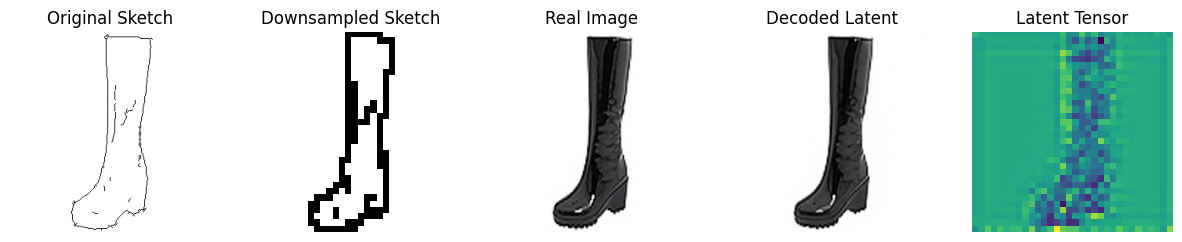

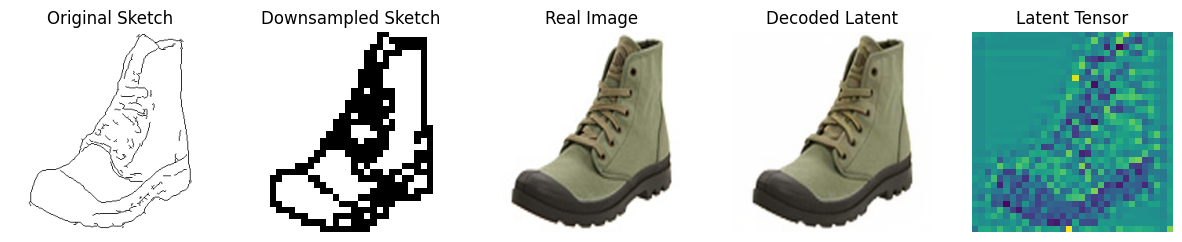

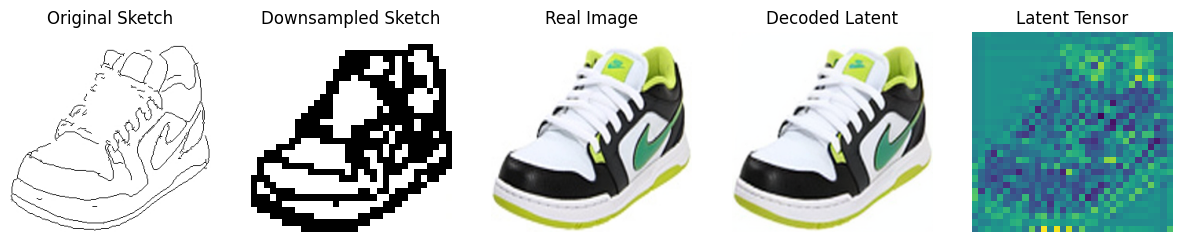

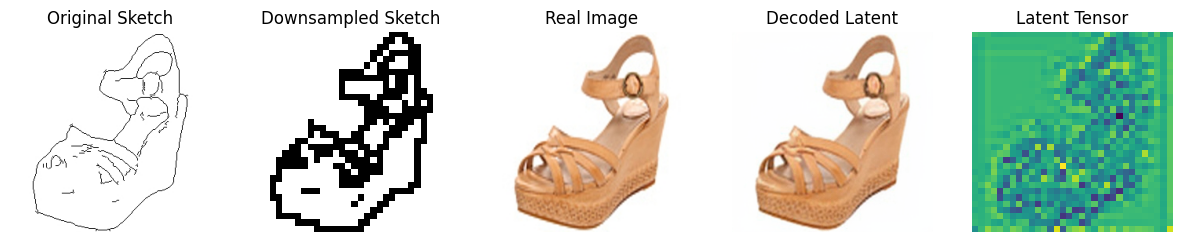

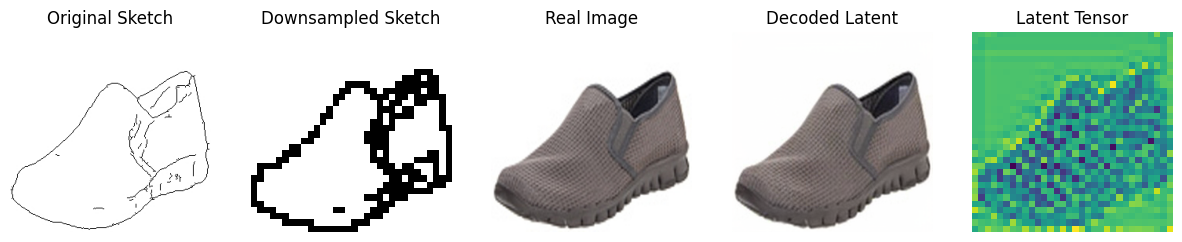

Downsampled: 5
Latents: 5


In [13]:
# --- Paths ---
PREPROCESS_LOCAL = Path("/content/data/preprocessed")
PREPROCESS_DRIVE = Path("/content/drive/MyDrive/edges2shoes_preprocessed")
(PREPROCESS_LOCAL / "downsampled").mkdir(parents=True, exist_ok=True)
(PREPROCESS_LOCAL / "latent").mkdir(parents=True, exist_ok=True)

images = list(TRAIN_DIR.glob("*.jpg"))    # [:5]
DISPLAY_IMAGES = False                    # if displaying uncomment line above to limit to 5

# --- MinPool definition (preserve dark sketch lines by pooling minima) ---
class MinPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)
    def forward(self, x):
        # min(x) == -max(-x)
        return -self.pool(-x)

sketch_transform = MinPool2d(kernel_size=8, stride=8)

# --- VAE ---
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
vae.eval()
print("Loaded VAE")

import matplotlib.pyplot as plt

def process_image(img_path):
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    sketch = img.crop((0, 0, w//2, h))
    real = img.crop((w//2, 0, w, h))

    sketch_t = T.ToTensor()(sketch).unsqueeze(0)
    real_t = T.ToTensor()(real).unsqueeze(0).to(device)

    # Downsample sketch
    sketch_t_down = sketch_transform(sketch_t)

    # Encode real image to latent
    with torch.no_grad():
        z = vae.encode(real_t).latent_dist.sample()

    # --- Display ---
    if DISPLAY_IMAGES:
      # Decode latent back to image for preview
      with torch.no_grad():
          real_decoded = vae.decode(z).sample  # access .sample
      fig, axes = plt.subplots(1, 5, figsize=(15, 4))

      axes[0].imshow(sketch)
      axes[0].set_title("Original Sketch")
      axes[0].axis("off")

      axes[1].imshow(sketch_t_down.squeeze(0).permute(1, 2, 0).cpu())
      axes[1].set_title("Downsampled Sketch")
      axes[1].axis("off")

      axes[2].imshow(real)
      axes[2].set_title("Real Image")
      axes[2].axis("off")

      real_img = real_decoded.squeeze(0).permute(1, 2, 0).cpu().clamp(0, 1)
      axes[3].imshow(real_img)
      axes[3].set_title("Decoded Latent")
      axes[3].axis("off")

      # Visualize latent tensor as grayscale
      latent_img = z.squeeze(0).mean(0).cpu()  # [C,H,W] -> [H,W]
      axes[4].imshow(latent_img, cmap="viridis")
      axes[4].set_title("Latent Tensor")
      axes[4].axis("off")

      plt.show()

    return sketch_t_down.squeeze(0), z.squeeze(0).cpu()

results = []
for img_path in images:
    sketch_latent, real_latent = process_image(img_path)
    fname = img_path.stem

    torch.save(sketch_latent, PREPROCESS_LOCAL / "downsampled" / f"{fname}.pt")     # save as matrix (.pt -> pytorch form)
    torch.save(real_latent, PREPROCESS_LOCAL / "latent" / f"{fname}.pt")

    results.append((fname, sketch_latent, real_latent))

# --- Print counts ---
print("Downsampled:", len(list((PREPROCESS_LOCAL / "downsampled").glob("*.pt"))))
print("Latents:", len(list((PREPROCESS_LOCAL / "latent").glob("*.pt"))))


### Data Loader
Implements a PyTorch `Dataset` that splits each 512x256 paired image into `(sketch, real)` halves of size 256x256.

In [11]:
class Edges2ShoesPairsPreprocessed(Dataset):
    def __init__(self, root_dir: str | os.PathLike):
        self.root_dir = Path(root_dir)
        if not self.root_dir.exists():
            raise FileNotFoundError(f"{self.root_dir} does not exist")
        self.files = sorted(self.root_dir.glob("*.pt"))
        if not self.files:
            raise FileNotFoundError(f"No preprocessed files found in {self.root_dir}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx: int):
        data = torch.load(self.files[idx])
        return {
            'sketch': data['sketch'],  # (3,32,32)
            'image': data['real'],     # (4,32,32)
            'path': str(self.files[idx])
        }


# --- Instantiate dataset and dataloader ---
BATCH_SIZE = 64
NUM_WORKERS = 8

train_dataset = Edges2ShoesPairsPreprocessed(PREPROCESS_LOCAL)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

print(f"Number of samples: {len(train_dataset)}, batch size: {BATCH_SIZE}")


Number of samples: 49825, batch size: 64


In [12]:
# Quick sanity check: iterate one batch and show shapes
batch = next(iter(train_loader))
print('Batch keys:', list(batch.keys()))
print('Sketch tensor:', batch['sketch'].shape, batch['sketch'].dtype, batch['sketch'].min().item(), batch['sketch'].max().item())
print('Image tensor:', batch['image'].shape, batch['image'].dtype, batch['image'].min().item(), batch['image'].max().item())

Batch keys: ['sketch', 'image', 'path']
Sketch tensor: torch.Size([64, 3, 32, 32]) torch.float32 1.0 1.0
Image tensor: torch.Size([64, 4, 32, 32]) torch.float32 -14.709486961364746 22.724632263183594


### Diffusion Setup

In [ ]:
# --- Diffusion setup in latent space ---
T = 200
beta_start = 1e-4
beta_end   = 0.02

betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]], dim=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

def q_sample(z0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(z0)
    sqrt_ac = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_om = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_ac * z0 + sqrt_om * noise

def sample_timesteps(batch_size):
    return torch.randint(low=0, high=T, size=(batch_size,), device=device)

def sinusoidal_time_embedding(timesteps, dim):
    device_ = timesteps.device
    half_dim = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device_) * -emb)
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb


### Conditional U-Net Class For Latent Space

In [ ]:
# --- Residual Block ---
class ResidualBlock(nn.Module):
    # 2 normalization layers, 2 convolutions, 1 conditional projection
    def __init__(self, in_ch, out_ch, cond_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch) # splits the in_ch into 8 groups and normalizes per group
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1) # convolutional layer with standard 3 x 3 kernel - pad 1 to maintain dimension
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.cond_proj = nn.Linear(cond_dim, 2*out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()

    def forward(self, x, cond):
        """
        (B is the number of samples in a forward pass)
        x:    latent feature map  [B, C, H, W]
        cond: conditioning vector [B, cond_dim]
        """
        gamma, beta = self.cond_proj(cond).chunk(2, dim=1) # Linear layer maps conditioning input vector to gamma and beta vectors
        gamma = gamma[..., None, None]; beta = beta[..., None, None] # Make them broadcastable over H, W

        h = self.conv1(F.silu(self.norm1(x))) # norm → activation → conv
        h = self.conv2(F.silu(self.norm2(h) * (1+gamma) + beta)) # norm → conditioning using FiLM → activation → conv

        return h + self.skip(x) # Residual connection

# --- Conditional Latent U-Net ---
class LatentUNet(nn.Module):
    # Built U-net architecture
    def __init__(self, in_ch=4, base_ch=64, time_dim=64, sketch_dim=64):
        super().__init__()
        cond_dim = time_dim + sketch_dim

        # --- Conditioning MLPs ---
        # Raw time embeddings and sketch embeddings may not be expressive enough - use MLPs to transform into richer feature vectors for FiLM conditioning
        self.time_mlp = nn.Sequential(nn.Linear(time_dim, time_dim), nn.SiLU(), nn.Linear(time_dim, time_dim)) # SiLU (Swish) is Sigmoid Linear Unit - like ReLU with better gradient flow
        self.sketch_mlp = nn.Sequential(nn.Linear(sketch_dim, sketch_dim), nn.SiLU(), nn.Linear(sketch_dim, sketch_dim))

        self.conv_in = nn.Conv2d(in_ch, base_ch, 3, padding=1)      # Maps the latent input into UNet feature space (4 input channels to 64 output)

        # --- Encoder blocks (downsampling path) ---
        self.down1 = ResidualBlock(base_ch, base_ch, cond_dim)      # first residual block, keeps channels (64 in, 64 out)
        self.down2 = ResidualBlock(base_ch, base_ch*2, cond_dim)    # second block, doubles channels for more representation power (64 in, 128 out)
        self.pool = nn.AvgPool2d(2)                                 # downsample spatially by 2 (32x32 → 16x16)

        self.down3 = ResidualBlock(base_ch*2, base_ch*2, cond_dim)  # third residual block, keeps channel count (128 in, 128 out)
        self.mid = ResidualBlock(base_ch*2, base_ch*2, cond_dim)    # bottleneck block: largest receptive field, mixes all features

        # --- Decoder blocks (upsampling path) ---
        self.up1 = ResidualBlock(base_ch*2, base_ch*2, cond_dim)    # first upsampling residual block (128 in, 128 out)
        self.up2 = ResidualBlock(base_ch*2, base_ch, cond_dim)      # second upsampling block reduces channels back to base_ch (128 in, 64 out)

        # --- Output convolution ---
        self.conv_out = nn.Conv2d(base_ch, in_ch, 3, padding=1)     # input 64 channels and output 4 channels again for latent space
        # Maps UNet feature map back to latent space shape (e.g., 4 channels for KL-VAE)
        # Produces the predicted noise for diffusion training


    def forward(self, x, t, sketch_emb):
        """
        x: (B, 4, 32, 32) - latent feature map (B = #samples)
        t: (B, 64) - time embedding
        """
        ste = sinusoidal_time_embedding(t, 64)
        t_emb = self.time_mlp(ste)
        sketch_emb = self.sketch_mlp(sketch_emb)

        cond = torch.cat([t_emb, sketch_emb], dim=1) # concatenate the time and sketch embeddings

        x1 = self.down1(self.conv_in(x), cond) #
        x2 = self.down2(x1, cond)
        x2p = self.pool(x2)
        x3 = self.down3(x2p, cond)
        m = self.mid(x3, cond)
        u1 = F.interpolate(self.up1(m, cond), size=x2.shape[-2:], mode="nearest")
        u2 = self.up2(u1, cond)
        return self.conv_out(u2)

# --- Sketch conditioning ---
class SketchEncoder(nn.Module):
    def __init__(self, embed_dim=64):
        super().__init__()
        self.conv = nn.Conv2d(3, embed_dim, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):  # x: (B,3,H,W)
        h = self.pool(F.silu(self.conv(x)))
        return h.flatten(1)  # (B, embed_dim)

# --- Instantiate ---
latent_channels = 4  # KL-VAE latent
unet = LatentUNet(in_ch=latent_channels).to(device)
sketch_encoder = SketchEncoder(embed_dim=64).to(device)

# Optimizer
opt = torch.optim.AdamW(list(unet.parameters()) + list(sketch_encoder.parameters()), lr=2e-4)

total_params = sum(p.numel() for p in unet.parameters()) + sum(p.numel() for p in sketch_encoder.parameters())
print("Parameters (M):", total_params / 1e6)


### Train U-Net with Pre-Trained VAE

In [ ]:
num_diff_epochs = 1

unet.train()
sketch_encoder.train()

for epoch in range(num_diff_epochs):
    pbar = tqdm(train_loader, desc=f"Diff Epoch {epoch+1}/{num_diff_epochs}")
    for batch in pbar:
        imgs = batch['image'].to(device)           # (B,3,H,W)
        sketches = batch['sketch'].to(device)      # assuming your dataset returns sketches
        print(next(vae.parameters()).device, next(unet.parameters()).device, imgs.device)

        with torch.no_grad():
            z0 = vae.encode(imgs).latent_dist.mean  # (B, latent_channels, H_latent, W_latent)

        t = sample_timesteps(z0.size(0))                # e.g., (B,)
        noise = torch.randn_like(z0)
        z_t = q_sample(z0, t, noise)                    # noisy latent

        # Encode sketch
        sketch_emb = sketch_encoder(sketches)           # (B, sketch_dim)

        # Predict noise
        noise_pred = unet(z_t, t.float(), sketch_emb)   # pass t as float for sinusoidal embedding

        # MSE loss
        loss = F.mse_loss(noise_pred, noise)

        # Optimizer step
        opt.zero_grad()
        loss.backward()
        opt.step()

        pbar.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch+1}: last batch loss = {loss.item():.4f}")
